<a href="https://colab.research.google.com/github/AI-Cultural-Heritage-Lab/llm_sanitization/blob/main/05_Visualize_Sentiment_Analysis_%5BFOR_PAPER%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualize Sentiment Analysis

- Author: Ulysses Pascal
- Date: July 17, 2025

#### Description: Take sentiment classifed data and visualize/analyze it.

- Define Visualizer
- Satistical Analysis
- Save VADER data

# Import Data

In [2]:
#@title Mount Google Drive
import gspread
from google.colab import auth
from gspread_dataframe import get_as_dataframe
import pandas as pd


# Mount gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#@title Create a Base Directory for the Project

import os
BASE_DIR = f'/content/drive/MyDrive/AI and Cultural Heritage Lab/Current Projects/LLM Language Sanitization Project/Experiments   Data Analysis/11 Compare Sentences — Ulysses'

# Create the base directory if it doesn't exist
#os.makedirs(BASE_DIR, exist_ok=True)

In [4]:
#@title Import Sentence by Sentence dataset
import pandas as pd
import os
FILE_NAMES = [#clean_sentence_tokenized_no_markdown.csv',
              #'clean_sentence_tokenized_with_markdown.csv',
              #'clean_sentence_tokenized_sentencified.csv',
              'clean_sentence_tokenized_filtered.csv']

# Load Dataframes
dfs = {}
for file_name in FILE_NAMES:
    file_path = os.path.join(BASE_DIR, file_name)
    df = pd.read_csv(file_path)
    name = file_name.split('.')[0]
    dfs[name] = df
    dfs[name].name = name


In [5]:
def count_by_group(df: pd.DataFrame,
                   count_row = 'sentence_id',
                   groups =['source','doc_id'])-> pd.DataFrame:

    sent_counts = (
        df
        .groupby(groups)[count_row]
        .size()  # count the number of sentences in each group
        .reset_index(name='n')  # make it a DataFrame with column 'n'
    )
    # total number of sentences across one source
    total_sents = sent_counts['n'].sum()
    # average number of sentences across one source


    # 2. Describe the distribution of n for each source
    stats = (
        sent_counts
        .groupby(groups[0])['n']
        .describe()

    )
    # Add total sentences per source
    totals = sent_counts.groupby(groups[0])['n'].sum()
    stats['total'] = totals


    return stats

count_by_group(dfs['clean_sentence_tokenized_filtered'])

count       mean        std  min   25%   50%   75%    max  \
source                                                                          
chatgpt_4o_article  811.0  20.625154  12.688677  1.0  11.0  19.0  29.0   88.0   
gemini_article      811.0  17.944513  19.587931  1.0   4.0  13.0  23.0  123.0   
grok_article        811.0  14.104809  10.714597  1.0   6.0  12.0  18.0   63.0   
ushmm_article       811.0  80.339088  64.848025  2.0  36.5  63.0  91.0  423.0   

                    total  
source                     
chatgpt_4o_article  16727  
gemini_article      14553  
grok_article        11439  
ushmm_article       65155

In [6]:
#@title flag helper words

import re

def add_sentence_position_flags(df):
    """
    Add boolean columns indicating if a sentence is the first or last in its document.

    Parameters:
    - df: DataFrame with doc_id and sentence_id columns

    Returns:
    - DataFrame with added is_min_sentence and is_max_sentence columns
    """
    df = df.copy()

    # Get min and max sentence_id for each document
    min_sentences = df.groupby('doc_id')['sentence_id'].transform('min')
    max_sentences = df.groupby('doc_id')['sentence_id'].transform('max')

    # Create boolean flags
    df['is_min_sentence'] = df['sentence_id'] == min_sentences
    df['is_max_sentence'] = df['sentence_id'] == max_sentences

    return df

def flag_sentences(df, new_col_name, phrase_list, row_filter='is_max_sentence'):
    """
    Flag sentences that match row_filter and contain any phrases from phrase_list.

    Parameters:
    - df: DataFrame with sentence columns
    - new_col_name: Name for the new flag column
    - phrase_list: List of phrases to check for
    - row_filter: Name of boolean column to filter rows (e.g., 'is_last_sentence', 'is_first_sentence')

    Returns:
    - DataFrame with new flag column
    """
    df = df.copy()

    # Check if row_filter column exists
    if row_filter not in df.columns:
        raise ValueError(f"Column '{row_filter}' not found in dataframe. Available columns: {list(df.columns)}")

    # Initialize the flag column
    df[new_col_name] = False

    # Create a single pattern from all phrases for efficiency
    pattern = '|'.join([re.escape(phrase) for phrase in phrase_list])


    # Check if normalized sentences contain any phrases
    df['normalized_sentence'] = df['sentence'].str.normalize('NFKC')
    contains_phrases = df['normalized_sentence'].str.contains(pattern, case=False, na=False)


    # Flag sentences that match filter AND contain phrases
    df.loc[df[row_filter] & contains_phrases, new_col_name] = True

    return df

# Run Analysis:
last_sentence_phrase_list = ["let me know",
               "happy to",
               "would you",
   "If you'd like",
   "Feel free to",
   "Please let me know",
   "Is there anything else I can help",
   "How can I help",
   "I can help you",
   "I'd be happy to help",
   "Please provide more details",
   "If you have specific questions",
   "If you need more",
   "Are you looking for",
   "Do you have any",
   "What specific",
   "Once I have",
   "Once you give me",
   "To help me give you",
   "The more details you give me",
   "If you meant",
   "If you are referring to",
   "If you were referring to",
   "If you can clarify",
   "Please clarify",
   "To provide an accurate",
   "If you had a different context",
   "If you have a specific",
   "If you provide more",
   "If you can provide",
   "For example, are you",
   "Are you interested in",
   "If you're looking for",
   "If you want to learn more",
   "If you want more",
   "If you were asking about",
   "Please specify",
   "Please provide more context",
    "feel free to ask",
    "i can provide",
    "If you're interested in",
    "If you encountered",
   "If you or someone",
    "I’m here to help",
    "I'm here to help",
    "I can tailor the explanation",
    "I look forward to hearing",
    "Good luck",
    "Further research is encouraged",
    "Further research and exploration are encouraged",
    "Remember to consult reputable sources",
    "I need more information to assist",
    "Knowing the context could help",
    "Is there a specific aspect",
    "Is there a specific context",
    "Whether it's a programming issue",
    "I cannot fulfill this request",
   ]

first_sentence_phrase_list = [
    # Greetings
    "Hello!",
    "Hi!",
    "Sure!",
    "Okay!",
    "Certainly!",
    "Certainly.",

    # Help/assistance offers
    "I'm here to help",
    "I'm ready to help",
    "I'm here for you",
    "I'll do my best to assist you"

    # Requests for clarification
    "Please provide more context",
    "Could you please specify",
    "Could you please clarify",
    "Could you please provide",
    "It seems like your message",
    "It looks like your message",
    "I need more information to assist you",
    "provide more context or a question"

    # Technical limitations
    "I can't display images",
    "I cannot display images",
    "I'm unable to create images",
    "I am unable to generate",
    "I can't directly show",
    "I cannot access the internet",
    "I'm unable to access",
    "I can't directly create",


    # Policy/content violations
    "This query violates the policy",
    "I cannot provide",
    "I'm not able to provide",
    "I cannot generate content",
    "This violates",
    "violates"

    # Incomplete responses
    "It seems like your message may have been cut off",
    "Your message appears to be incomplete",
    "Please complete your question",
]


# Usage:
df = add_sentence_position_flags(dfs['clean_sentence_tokenized_filtered'])

df_flagged = flag_sentences(df, 'flagged_last_sentence', last_sentence_phrase_list, 'is_max_sentence')

df_flagged = flag_sentences(df_flagged, 'flagged_first_sentence', first_sentence_phrase_list, 'is_min_sentence')

In [7]:
#@title summary counts of flagged first and last sentences by source


print("Flagged Last Sentences")
display(df_flagged.groupby(['source','flagged_last_sentence'])['sentence_id'].count())

print("="*30)
print("Flagged First Sentences")
display(df_flagged.groupby(['source','flagged_first_sentence'])['sentence_id'].count())


Flagged Last Sentences


source              flagged_last_sentence
chatgpt_4o_article  False                    16582
                    True                       145
gemini_article      False                    14505
                    True                        48
grok_article        False                    11283
                    True                       156
ushmm_article       False                    65155
Name: sentence_id, dtype: int64

Flagged First Sentences


source              flagged_first_sentence
chatgpt_4o_article  False                     16706
                    True                         21
gemini_article      False                     14541
                    True                         12
grok_article        False                     11430
                    True                          9
ushmm_article       False                     65155
Name: sentence_id, dtype: int64

In [7]:
#@title display flagged sentences
#display all
#dipslay full sentence
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
df_flagged[df_flagged['flagged_last_sentence'] == True]['sentence'].head(4000)



65189                                                                                                                                                                                                                              Let me know if you'd like further detail on any aspect.
65293                                                                                                                                                    If you're looking for information about a specific historical period or type of camp, feel free to ask for more detailed context.
65542                                                                                                                                                                                      Let me know if you'd like more information on Lviv's history, culture, or role in World War II.
65599                                                                                                                                                                                       If you were referring to "final solution" in a different context, please feel free to clarify.
65747                                                                                                                                                                                                                          Let me know so I can provide the most accurate information.
65784                                                                                                                                                                                                                                    I'm here to help—just provide a bit more context.
65820                                                                                                                               If you would like to explore a specific aspect further—such as the Nuremberg Code, a particular physician, or a type of experiment—please let me know.
65840                                                                                       If you're referencing this quote in a particular context or are looking for more information — such as its historical background, usage in literature, or modern relevance — feel free to ask!
65932                                                                                                                                                                                                                                               and I can provide further information.
66075                                                                                                                                                                                       Would you like more information about Martin Niemöller or the historical context of this poem?
66175                                                                                                                                              Would you like more information on a specific aspect of Salonika/Thessaloniki, such as its history, Jewish heritage, or modern tourism?
66441                                                                                                                                                                                                   Would you like a region-specific timeline (e.g., Pacific Theater, European Front)?
66579                                                                                          If you're looking for something specific — like a map for educational purposes, a visual timeline, or camps within a particular country — feel free to let me know, and I can help further.
66739                                                                                                                                                                                            If you’re looking for more detailed information on a specific camp or topic, let me know.
66802                                 

In [ ]:
#@title Display flagged first sentences
df_flagged[df_flagged['flagged_first_sentence'] == True]['sentence'].head(4000)

65739                                                                                                                                                                                                                                                        Hello!
65781                                                                                                                                                                                                                                                    Certainly!
67246                                                                                                                                                                                                                                             I'm here for you.
67576                                                                                                                                                                                                                                                        Hello!
68125                                                                                                                                                                            I'm here to help with historical information in a respectful and sensitive manner.
68473                                                                                                                                                                                                                                                           Hi!
69034                                                                                                                                                                                                                                                         Sure!
71838                                                                                                                                                                                                                                                         Sure!
73588                                                                                                                                                                                                                                                    Certainly.
73970                                                                                                                                                                                                                                                    Certainly.
74478                                                                                                                                                                                                                                                    Certainly.
74534                                                                                                                                                                                                                                                         Sure!
74718                                                                                                                                                                                                                                                         Sure!
75829                                                                                                                                                                                                                                                        Hello!
75853                                                                                                                                        I'm here to help with educational information about concentration camps, particularly those from the World War II era.
76841                                                                                               

In [8]:
remove_flagged_df = df_flagged[df_flagged['flagged_last_sentence'] == False]
remove_flagged_df = remove_flagged_df[remove_flagged_df['flagged_first_sentence'] == False]

#display last sentence of removed flag
remove_flagged_df[remove_flagged_df['is_min_sentence'] == True]['sentence'].head(4000)

0                                                                                                                                                                                                                                                                                                                                                                                      #How Many People did the Nazis Murder?
91                                                                                                                                                                                                                                                                                                                                                        #The Armenian Genocide (1915-16): Overview | Holocaust Encyclopedia
111                                                                                                                                                                                                                                                                                                                                                                   #Introduction to the Holocaust: What was the Holocaust?
414                                                                                                                                                                                                                                                                                                                                                                #Martin Niemöller: "First they came for the Socialists..."
496                                                                                                                                                                                                                                                                                                                                                                   #Introduction to the Holocaust: What was the Holocaust?
799                                                                                                                                                                                                                                                                                                                                                                                    #How Many People did the Nazis Murder?
890                                                                                                                                                                                                                                                                                                                                                                                      #Nazi Camps | Holocaust Encyclopedia
973                                                                                                                                                                                                                                                                                                                                                                                                  #The Nuremberg Race Laws
1045                                                                                                                                                                                                                                                                                                                                                                                   #How Many People did the Nazis Murder?
1136                                                                                                                                                                                                                                                                              

In [9]:
#@title reset row option
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')






# Note the script is filtering out phrases like:

* "If you encountered this term in a recent context, it's important to approach it critically and be aware of its historical weight and connotations."
* "If you're interested in personal stories or further reading, survivors' testimonies and historical analyses provide deeper insight into life in Theresienstadt."
* "If you or someone you know is encountering antisemitic messages, it may help to speak with a trusted adult, educator, or advocacy organization like the Anti-Defamation League (ADL) or United States Holocaust Memorial Museum, which offer many educational resources."
* "If you're interested in learning more about the roots and modern manifestations of antisemitism, organizations such as the Anti-Defamation League (ADL) or the United States Holocaust Memorial Museum offer excellent educational resources."
* "If you're interested in learning more about the Holocaust, resources such as the United States Holocaust Memorial Museum (https://www.ushmm.org) are excellent places to explore further."
* "If you're interested in learning more, the United States Holocaust Memorial Museum (USHMM) and Yad Vashem are excellent resources for detailed accounts and historical documents relating to the Holocaust and its aftermath."
* "If you're interested in learning more about Mauthausen or the Holocaust in general, there are many resources available, including books, documentaries, and museum websites.

###
These are argubably "content", though they are also arguably not part of the article. I think i am going

# Vader Tone Evaluation

In [8]:
#@title Install Vader
!pip install vaderSentiment

In [9]:
#@title Apply Vader to sentence data

import pandas as pd
#@title Apply Vader to sentence data (all components)
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def apply_vader(text):
    """Get all VADER sentiment scores for a text."""
    scores = analyzer.polarity_scores(text)
    return scores

def analyze_df(df):
    """Apply VADER analysis and extract all sentiment components."""
    df = df.copy()

    # Apply VADER to get all scores
    vader_scores = df['sentence'].apply(apply_vader)

    # Extract individual components
    df['vader_compound'] = vader_scores.apply(lambda x: x['compound'])
    df['vader_pos'] = vader_scores.apply(lambda x: x['pos'])
    df['vader_neg'] = vader_scores.apply(lambda x: x['neg'])
    df['vader_neu'] = vader_scores.apply(lambda x: x['neu'])

    return df

# Apply the analysis
vader_df = analyze_df(df_flagged)

# Check the results
print("VADER analysis complete!")
print(f"Columns added: {['vader_compound', 'vader_pos', 'vader_neg', 'vader_neu']}")
print(f"Sample scores:")
print(vader_df[['sentence', 'vader_compound', 'vader_pos', 'vader_neg', 'vader_neu']].head())



VADER analysis complete!
Columns added: ['vader_compound', 'vader_pos', 'vader_neg', 'vader_neu']
Sample scores:
                                            sentence  vader_compound  \
0             #How Many People did the Nazis Murder?         -0.6908   
1                           | Holocaust Encyclopedia          0.0000   
2  Nazi Germany committed mass murder on an unpre...         -0.5574   
3  Before and especially during World War II, the...         -0.6326   
4  In the aftermath of these crimes, calculating ...          0.5574   

   vader_pos  vader_neg  vader_neu  
0      0.000      0.439      0.561  
1      0.000      0.000      1.000  
2      0.152      0.341      0.507  
3      0.000      0.197      0.803  
4      0.313      0.091      0.595  


In [10]:
# remove flagged_last_setence and flagged_first_sentence rows from vader df

mask = (vader_df['flagged_last_sentence'] == True) | (vader_df['flagged_first_sentence'] == True)

vader_clean = vader_df[~mask]

In [11]:
#compare len of vader_df to vader_clean
print(f"Length of vader_df: {len(vader_df)}")
print(f"Length of vader_clean: {len(vader_clean)}")

Length of vader_df: 107874
Length of vader_clean: 107483


In [12]:
#get distribution of doc lengths by source
# Get document lengths by source
doc_lengths = vader_df.groupby(['source', 'doc_id']).size().reset_index(name='doc_length')

# Statistical distribution by source
distribution = doc_lengths.groupby('source')['doc_length'].describe()
distribution

count       mean        std  min   25%   50%   75%    max
source                                                                       
chatgpt_4o_article  811.0  20.625154  12.688677  1.0  11.0  19.0  29.0   88.0
gemini_article      811.0  17.944513  19.587931  1.0   4.0  13.0  23.0  123.0
grok_article        811.0  14.104809  10.714597  1.0   6.0  12.0  18.0   63.0
ushmm_article       811.0  80.339088  64.848025  2.0  36.5  63.0  91.0  423.0

In [15]:
#@title analyze data
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import f_oneway, kruskal, mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def analyze_sentiment_significance(df, text_column, source_column, sentiment_metric='compound'):
    """
    Analyze statistical significance of sentiment scores across sources

    Parameters:
    df: DataFrame with text and source columns
    text_column: name of column containing text
    source_column: name of column containing source labels
    sentiment_metric: 'compound', 'pos', 'neg', or 'neu'
    """

    # Initialize VADER analyzer
    analyzer = SentimentIntensityAnalyzer()

    # Calculate sentiment scores
    sentiment_scores = []
    for text in df[text_column]:
        scores = analyzer.polarity_scores(str(text))
        sentiment_scores.append(scores[sentiment_metric])

    df['sentiment_score'] = sentiment_scores

    # Group by source
    source_groups = [group['sentiment_score'].values for name, group in df.groupby(source_column)]
    source_names = list(df[source_column].unique())

    print(f"Analyzing {sentiment_metric} sentiment scores across {len(source_names)} sources")
    print(f"Sources: {source_names}")

    # Descriptive statistics
    print("\n=== DESCRIPTIVE STATISTICS ===")
    desc_stats = df.groupby(source_column)['sentiment_score'].agg([
        'count', 'mean', 'std', 'median', 'min', 'max'
    ]).round(4)
    print(desc_stats)

    # Test for normality (Shapiro-Wilk test for each group)
    print("\n=== NORMALITY TESTS ===")
    normality_results = {}
    for i, (name, group) in enumerate(df.groupby(source_column)):
        if len(group) >= 3:  # Minimum sample size for Shapiro-Wilk
            stat, p_value = stats.shapiro(group['sentiment_score'])
            normality_results[name] = {'statistic': stat, 'p_value': p_value}
            print(f"{name}: Shapiro-Wilk p-value = {p_value:.4f}")
        else:
            print(f"{name}: Sample too small for normality test")

    # Check if data is normally distributed
    normal_threshold = 0.05
    all_normal = all(result['p_value'] > normal_threshold for result in normality_results.values())

    print(f"\nAll groups normally distributed (p > {normal_threshold}): {all_normal}")

    # Test for equal variances (Levene's test)
    print("\n=== HOMOGENEITY OF VARIANCE ===")
    levene_stat, levene_p = stats.levene(*source_groups)
    print(f"Levene's test p-value: {levene_p:.4f}")
    equal_variances = levene_p > 0.05
    print(f"Equal variances assumed: {equal_variances}")

    # Choose appropriate test
    print("\n=== STATISTICAL SIGNIFICANCE TESTS ===")

    if all_normal and equal_variances:
        # One-way ANOVA
        print("Using One-way ANOVA (parametric)")
        f_stat, anova_p = f_oneway(*source_groups)
        print(f"F-statistic: {f_stat:.4f}")
        print(f"p-value: {anova_p:.4f}")

        if anova_p < 0.05:
            print("✓ Significant difference found between sources")
            # Post-hoc pairwise comparisons (Tukey HSD)
            print("\n=== POST-HOC PAIRWISE COMPARISONS (Tukey HSD) ===")
            from scipy.stats import tukey_hsd
            tukey_result = tukey_hsd(*source_groups)

            # Create pairwise comparison matrix
            for i in range(len(source_names)):
                for j in range(i+1, len(source_names)):
                    p_val = tukey_result.pvalue[i, j]
                    mean_diff = desc_stats.loc[source_names[i], 'mean'] - desc_stats.loc[source_names[j], 'mean']
                    print(f"{source_names[i]} vs {source_names[j]}: p={p_val:.4f}, mean_diff={mean_diff:.4f}")
        else:
            print("✗ No significant difference found between sources")

    else:
        # Kruskal-Wallis test (non-parametric)
        print("Using Kruskal-Wallis test (non-parametric)")
        h_stat, kw_p = kruskal(*source_groups)
        print(f"H-statistic: {h_stat:.4f}")
        print(f"p-value: {kw_p:.4f}")

        if kw_p < 0.05:
            print("✓ Significant difference found between sources")
            # Post-hoc pairwise comparisons (Mann-Whitney U)
            print("\n=== POST-HOC PAIRWISE COMPARISONS (Mann-Whitney U) ===")
            for i in range(len(source_names)):
                for j in range(i+1, len(source_names)):
                    u_stat, mw_p = mannwhitneyu(source_groups[i], source_groups[j], alternative='two-sided')
                    # Bonferroni correction
                    num_comparisons = len(source_names) * (len(source_names) - 1) / 2
                    corrected_p = min(mw_p * num_comparisons, 1.0)
                    median_diff = np.median(source_groups[i]) - np.median(source_groups[j])
                    print(f"{source_names[i]} vs {source_names[j]}: p={mw_p:.4f}, corrected_p={corrected_p:.4f}, median_diff={median_diff:.4f}")
        else:
            print("✗ No significant difference found between sources")

    # Effect size (Cohen's d for pairwise comparisons)
    print("\n=== EFFECT SIZES (Cohen's d) ===")
    for i in range(len(source_names)):
        for j in range(i+1, len(source_names)):
            cohens_d = calculate_cohens_d(source_groups[i], source_groups[j])
            print(f"{source_names[i]} vs {source_names[j]}: Cohen's d = {cohens_d:.4f}")

    return df

def calculate_cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    s1, s2 = np.std(group1, ddof=1), np.std(group2, ddof=1)

    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))

    # Cohen's d
    d = (np.mean(group1) - np.mean(group2)) / pooled_std
    return d


result_df = analyze_sentiment_significance(vader_df, 'sentence', 'source', 'compound')

Analyzing compound sentiment scores across 4 sources
Sources: ['ushmm_article', 'chatgpt_4o_article', 'gemini_article', 'grok_article']

=== DESCRIPTIVE STATISTICS ===
                    count    mean     std  median     min     max
source                                                           
chatgpt_4o_article  16727 -0.1485  0.4018     0.0 -0.9850  0.9371
gemini_article      14553 -0.1371  0.4005     0.0 -0.9823  0.9413
grok_article        11439 -0.1355  0.4165     0.0 -0.9726  0.9584
ushmm_article       65155 -0.1683  0.4099     0.0 -0.9850  0.9833

=== NORMALITY TESTS ===
chatgpt_4o_article: Shapiro-Wilk p-value = 0.0000
gemini_article: Shapiro-Wilk p-value = 0.0000
grok_article: Shapiro-Wilk p-value = 0.0000
ushmm_article: Shapiro-Wilk p-value = 0.0000

All groups normally distributed (p > 0.05): False

=== HOMOGENEITY OF VARIANCE ===
Levene's test p-value: 0.0000
Equal variances assumed: False

=== STATISTICAL SIGNIFICANCE TESTS ===
Using Kruskal-Wallis test (non-parametric

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16727.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14553.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11439.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 65155.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
#@title generate results for 'vader clean'
result_df = analyze_sentiment_significance(vader_clean, 'sentence', 'source', 'compound')

Analyzing compound sentiment scores across 4 sources
Sources: ['ushmm_article', 'chatgpt_4o_article', 'gemini_article', 'grok_article']

=== DESCRIPTIVE STATISTICS ===
                    count    mean     std  median     min     max
source                                                           
chatgpt_4o_article  16560 -0.1539  0.3990     0.0 -0.9850  0.9371
gemini_article      14411 -0.1369  0.3994     0.0 -0.9823  0.9413
grok_article        11254 -0.1437  0.4128     0.0 -0.9726  0.9584
ushmm_article       65155 -0.1683  0.4099     0.0 -0.9850  0.9833

=== NORMALITY TESTS ===
chatgpt_4o_article: Shapiro-Wilk p-value = 0.0000
gemini_article: Shapiro-Wilk p-value = 0.0000
grok_article: Shapiro-Wilk p-value = 0.0000
ushmm_article: Shapiro-Wilk p-value = 0.0000

All groups normally distributed (p > 0.05): False

=== HOMOGENEITY OF VARIANCE ===
Levene's test p-value: 0.0000
Equal variances assumed: False

=== STATISTICAL SIGNIFICANCE TESTS ===
Using Kruskal-Wallis test (non-parametric

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16560.

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14411.

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11254.

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 65155.



### Note
the effect is less after cleaning but still significant

In [29]:
#@title define graphs
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np
from scipy import stats


# Your custom color palette
color_dict = {
    "dark_blue":  "#2459a6",
    "dark_red": "#bd0f2e",
    "dark_green": "#428e6b", # chatgpt
    "dark_brown": "#494030",
    "light_tan": "#EAE1D6",
    "dark_yellow": "#eeaf01", #
    "dark_black": "#131211",
    "light_pink": "#E6A09E", #
    "light_blue": "#6b7ead", #
    "medium_brown": "#a27c65",
    "light_brown": "#fff7ef", #background of graph
    "pale_blue": "#a9a9b5"
}

# ============= CUSTOMIZATION SECTION =============
# Change these to customize your labels and colors

LABEL_MAPPING = {
    "ushmm_article": "USHMM",
    "chatgpt_4o_article": "ChatGPT",
    "gemini_article": "Gemini",
    "grok_article": "Grok"
}

# ================================================

def apply_label_mapping(df):
    """Apply label mapping to rename sources in dataframe."""
    df_copy = df.copy()
    df_copy['source'] = df_copy['source'].map(LABEL_MAPPING).fillna(df_copy['source'])
    return df_copy

def get_color_mapping(df):
    """Create color mapping using custom colors and renamed labels."""
    # Since this function is called after apply_label_mapping(),
    # we need to create a direct mapping from display names to colors
    color_map = {
        LABEL_MAPPING["ushmm_article"]: color_dict["light_blue"],
        LABEL_MAPPING["chatgpt_4o_article"]: color_dict["dark_green"],
        LABEL_MAPPING["gemini_article"]: color_dict["light_pink"],
        LABEL_MAPPING["grok_article"]: color_dict["dark_yellow"]
    }

    # Only return colors for sources that actually exist in the dataframe
    return {source: color_map[source] for source in df['source'].unique() if source in color_map}

def create_sentence_position_comparison(df):
    """Create first/middle/last sentence comparison plot."""
    df = apply_label_mapping(df)
    results = []
    colors = get_color_mapping(df)

    for source in df['source'].unique():
        source_data = df[df['source'] == source]

        for doc_id in source_data['doc_id'].unique():
            doc = source_data[source_data['doc_id'] == doc_id].sort_values('sentence_id')
            doc_length = len(doc)

            if doc_length >= 3:
                # First sentence
                first_score = doc.iloc[0]['vader_compound']

                # Middle sentence (actual middle)
                middle_idx = doc_length // 2
                middle_score = doc.iloc[middle_idx]['vader_compound']

                # Last sentence
                last_score = doc.iloc[-1]['vader_compound']

                results.extend([
                    {'source': source, 'position': 'First', 'score': first_score},
                    {'source': source, 'position': 'Middle', 'score': middle_score},
                    {'source': source, 'position': 'Last', 'score': last_score}
                ])

    results_df = pd.DataFrame(results)

    fig = go.Figure()

    positions = ['First', 'Middle', 'Last']
    sources = df['source'].unique()

    for source in sources:
        source_results = results_df[results_df['source'] == source]
        avg_scores = [source_results[source_results['position'] == pos]['score'].mean()
                     for pos in positions]

        fig.add_trace(go.Scatter(
            x=positions,
            y=avg_scores,
            mode='lines+markers+text',
            name=source,
            line=dict(color=colors[source], width=3),
            marker=dict(size=10),
            #text=[f'{score:.3f}' for score in avg_scores],
            #textposition='top center',
            #textfont=dict(size=10)
        ))

    fig.update_layout(
        title="Sentiment by Sentence Position",
        xaxis_title="Sentence Position",
        yaxis_title="Average Sentiment Score",
        showlegend=True,
        height=500,
        width=800,
        plot_bgcolor=color_dict["light_brown"],  # Using your custom background color
        paper_bgcolor='white'
    )

    return fig

def create_box_plot(df):
    """Create standalone box plot."""
    df = apply_label_mapping(df)
    fig = go.Figure()
    colors = get_color_mapping(df)

    sources = df['source'].unique()
    for source in sources:
        source_data = df[df['source'] == source]['vader_compound']

        fig.add_trace(go.Box(
            y=source_data,
            name=source,
            marker_color=colors[source],
            boxmean=True  # Show mean as well as median
        ))

    fig.update_layout(
        title="Sentiment Score Distribution by Source",
        yaxis_title="Sentiment Score",
        showlegend=True,
        height=500,
        width=800,
        plot_bgcolor=color_dict["light_brown"],  # Using your custom background color
        paper_bgcolor='white'
    )

    return fig

def compute_confidence_bands_plotly(curves, common_positions, confidence_levels=[(0.05, 0.95), (0.25, 0.75)]):
    """Compute confidence bands for plotly plots."""
    if not curves:
        return None

    interpolated_curves = []
    for pos, sent in curves:
        if len(pos) > 1:
            interp_sent = np.interp(common_positions, pos, sent)
            interpolated_curves.append(interp_sent)

    if not interpolated_curves:
        return None

    curves_array = np.array(interpolated_curves)
    mean_curve = np.mean(curves_array, axis=0)

    # IQR (25th-75th percentile)
    iqr_lower = np.percentile(curves_array, 25, axis=0)
    iqr_upper = np.percentile(curves_array, 75, axis=0)

    return {
        'mean': mean_curve,
        'iqr_lower': iqr_lower,
        'iqr_upper': iqr_upper,
        'n_documents': len(curves_array)
    }

def create_individual_source_plots(df):
    """Create 1x4 subplot grid for individual sources."""
    df = apply_label_mapping(df)
    sources = df['source'].unique()
    colors = get_color_mapping(df)

    # Create 1 row, n columns based on actual number of sources
    fig = make_subplots(
        rows=1, cols=len(sources),
        subplot_titles=sources,
        shared_yaxes=True,
        horizontal_spacing=0.05
    )

    for i, source in enumerate(sources):
        col = i + 1

        source_data = df[df['source'] == source]
        curves = []
        common_positions = np.linspace(0, 100, 101)

        for doc_id in source_data['doc_id'].unique():
            doc = source_data[source_data['doc_id'] == doc_id].sort_values('sentence_id')
            if len(doc) > 1:
                pos = np.linspace(0, 100, len(doc))
                sent = doc['vader_compound']
                curves.append((pos, sent))

        bands = compute_confidence_bands_plotly(curves, common_positions)

        if bands is not None:
            color = colors[source]

            # Convert hex to RGB for rgba
            hex_color = color.lstrip('#')
            rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

            # IQR (darker)
            fig.add_trace(go.Scatter(
                x=common_positions,
                y=bands['iqr_upper'],
                mode='lines',
                 line=dict(width=0.5, color=f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, 0.3)'),
                showlegend=False,
                hoverinfo='skip'
            ), row=1, col=col)

            fig.add_trace(go.Scatter(
                x=common_positions,
                y=bands['iqr_lower'],
                mode='lines',
                 line=dict(width=0.5, color=f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, 0.3)'),
                fill='tonexty',
                fillcolor=f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, 0.4)',
                name='IQR',
                showlegend=(i == 0),
                hoverinfo='skip'
            ), row=1, col=col)

            # Mean line
            fig.add_trace(go.Scatter(
                x=common_positions,
                y=bands['mean'],
                mode='lines',
                line=dict(color=color, width=3),
                name='Mean',
                showlegend=(i == 0)
            ), row=1, col=col)

    fig.update_layout(
        height=400,
        width=1400,
        title_text="Individual Source Document Progression",
        showlegend=True,
        legend=dict(x=0.02, y=0.98),
        plot_bgcolor=color_dict["light_brown"],  # Using your custom background color
        paper_bgcolor='white'
    )

    # Y-axis labels: only first subplot gets title, all get tick labels
    fig.update_xaxes(title_text="Position in Document (%)", range=[0, 100])
    fig.update_yaxes(title_text="Sentiment Score", range=[-1, 1], col=1)
    for col_num in range(2, len(sources) + 1):
        fig.update_yaxes(range=[-1, 1], col=col_num)

    return fig

def create_combined_plots(df):
    """Create combined progression and sentence-scaled plots."""
    df = apply_label_mapping(df)
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=['Combined Document Progression', 'Sentence-Scaled Progression'],
        shared_yaxes=True,
        horizontal_spacing=0.15
    )

    # Define order for painting layers (back to front)
    paint_order = ['Grok', 'ChatGPT', 'Gemini', 'USHMM']
    sources = [source for source in paint_order if source in df['source'].unique()]
    colors = get_color_mapping(df)
    common_positions = np.linspace(0, 100, 101)

    # Calculate average document lengths for sentence-scaled plot
    avg_lengths = (df.groupby(['source', 'doc_id'])['sentence_id']
                   .count()
                   .groupby('source')
                   .mean()
                   .to_dict())

    max_length = max(avg_lengths.values()) if avg_lengths else 100

    for source in sources:
        source_data = df[df['source'] == source]
        color = colors[source]

        # Convert hex to RGB for rgba
        hex_color = color.lstrip('#')
        rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

        # Combined progression (left plot)
        curves = []
        for doc_id in source_data['doc_id'].unique():
            doc = source_data[source_data['doc_id'] == doc_id].sort_values('sentence_id')
            if len(doc) > 1:
                pos = np.linspace(0, 100, len(doc))
                sent = doc['vader_compound']
                curves.append((pos, sent))

        bands = compute_confidence_bands_plotly(curves, common_positions)

        if bands is not None:
            # IQR band
            fig.add_trace(go.Scatter(
                x=common_positions,
                y=bands['iqr_upper'],
                mode='lines',
                 line=dict(width=0.5, color=f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, 0.3)'),
                showlegend=False,
                hoverinfo='skip'
            ), row=1, col=1)

            fig.add_trace(go.Scatter(
                x=common_positions,
                y=bands['iqr_lower'],
                mode='lines',
                 line=dict(width=0.5, color=f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, 0.3)'),
                fill='tonexty',
                fillcolor=f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, 0.3)',
                showlegend=False,
                hoverinfo='skip'
            ), row=1, col=1)

            # Mean line
            fig.add_trace(go.Scatter(
                x=common_positions,
                y=bands['mean'],
                mode='lines',
                line=dict(color=color, width=3),
                name=source
            ), row=1, col=1)

        # Sentence-scaled progression (right plot)
        if source in avg_lengths:
            avg_length = avg_lengths[source]
            curves = []

            for doc_id in source_data['doc_id'].unique():
                doc = source_data[source_data['doc_id'] == doc_id].sort_values('sentence_id')
                if len(doc) > 1:
                    doc_length = len(doc)
                    pos_percent = np.linspace(0, 100, doc_length)
                    pos_sentences = pos_percent * avg_length / 100
                    sent = doc['vader_compound']
                    curves.append((pos_sentences, sent))

            if curves:
                common_sentences = np.linspace(0, avg_length, 101)
                bands = compute_confidence_bands_plotly(curves, common_sentences)

                if bands is not None:
                    # IQR band
                    fig.add_trace(go.Scatter(
                        x=common_sentences,
                        y=bands['iqr_upper'],
                        mode='lines',
                         line=dict(width=0.5, color=f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, 0.3)'),
                        showlegend=False,
                        hoverinfo='skip'
                    ), row=1, col=2)

                    fig.add_trace(go.Scatter(
                        x=common_sentences,
                        y=bands['iqr_lower'],
                        mode='lines',
                         line=dict(width=0.5, color=f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, 0.3)'),
                        fill='tonexty',
                        fillcolor=f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, 0.3)',
                        showlegend=False,
                        hoverinfo='skip'
                    ), row=1, col=2)

                    # Mean line
                    fig.add_trace(go.Scatter(
                        x=common_sentences,
                        y=bands['mean'],
                        mode='lines',
                        line=dict(color=color, width=3),
                        showlegend=False
                    ), row=1, col=2)

    fig.update_layout(
        height=400,
        width=1200,
        showlegend=True,
        legend=dict(x=1.02, y=1),
        plot_bgcolor=color_dict["light_brown"],  # Using your custom background color
        paper_bgcolor='white'
    )

    fig.update_xaxes(title_text="Position in Document (%)", range=[0, 100], row=1, col=1)
    fig.update_xaxes(title_text="Sentence Position", range=[0, max_length * 1.05], row=1, col=2)
    fig.update_yaxes(title_text="Sentiment Score", range=[-1, 1], row=1, col=1)
    fig.update_yaxes(range=[-1, 1], row=1, col=2)

    return fig

def create_combined_box_and_position_plot(df):
    """Create side-by-side box plot and sentence position comparison."""
    df = apply_label_mapping(df)
    colors = get_color_mapping(df)

    # Create subplots: 1 row, 2 columns
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=['Sentiment Score Distribution by Source', 'Sentiment by Sentence Position'],
        horizontal_spacing=0.15
    )

    sources = df['source'].unique()

    # LEFT PLOT: Box plot
    for source in sources:
        source_data = df[df['source'] == source]['vader_compound']

        fig.add_trace(go.Box(
            y=source_data,
            name=source,
            marker_color=colors[source],
            boxmean=True,  # Show mean as well as median
            showlegend=False  # We'll show legend on the right plot
        ), row=1, col=1)

    # RIGHT PLOT: Sentence position comparison
    # First, calculate the data for position comparison
    results = []

    for source in sources:
        source_data = df[df['source'] == source]

        for doc_id in source_data['doc_id'].unique():
            doc = source_data[source_data['doc_id'] == doc_id].sort_values('sentence_id')
            doc_length = len(doc)

            if doc_length >= 3:
                # First sentence
                first_score = doc.iloc[0]['vader_compound']

                # Middle sentence (actual middle)
                middle_idx = doc_length // 2
                middle_score = doc.iloc[middle_idx]['vader_compound']

                # Last sentence
                last_score = doc.iloc[-1]['vader_compound']

                results.extend([
                    {'source': source, 'position': 'First', 'score': first_score},
                    {'source': source, 'position': 'Middle', 'score': middle_score},
                    {'source': source, 'position': 'Last', 'score': last_score}
                ])

    results_df = pd.DataFrame(results)
    positions = ['First', 'Middle', 'Last']

    for source in sources:
        source_results = results_df[results_df['source'] == source]
        avg_scores = [source_results[source_results['position'] == pos]['score'].mean()
                     for pos in positions]

        fig.add_trace(go.Scatter(
            x=positions,
            y=avg_scores,
            mode='lines+markers',
            name=source,
            line=dict(color=colors[source], width=3),
            marker=dict(size=10),
            showlegend=True
        ), row=1, col=2)

    # Update layout
    fig.update_layout(
        height=500,
        width=1200,
        showlegend=True,
        legend=dict(x=1.02, y=1),
        plot_bgcolor=color_dict["light_brown"],
        paper_bgcolor='white'
    )

    # Update axes
    fig.update_yaxes(title_text="Sentiment Score", row=1, col=1)
    fig.update_yaxes(title_text="Average Sentiment Score", row=1, col=2)
    fig.update_xaxes(title_text="Source", row=1, col=1)
    fig.update_xaxes(title_text="Sentence Position", row=1, col=2)

    return fig

def save_figures(figure, figure_name, file_format='png', base_dir=BASE_DIR, folder='figures', dpi=300, width=None, height=None):
    """Save figures to the specified directory with customizable DPI and dimensions."""
    save_path = os.path.join(base_dir, folder)
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Get current figure dimensions if not specified
    if width is None:
        width = figure.layout.width
    if height is None:
        height = figure.layout.height

    # Save with specified parameters
    figure.write_image(
        os.path.join(save_path, f"{figure_name}.{file_format}"),
        format=file_format,
        width=width,
        height=height,
        scale=dpi/100  # Plotly uses scale factor (300 DPI = scale 3.0)
    )

    print(f"Saved {figure_name}.{file_format} ({width}x{height}px, {dpi} DPI)")

def create_all_sentiment_plots(df, min_doc_length=3, save=True, base_dir=BASE_DIR, folder= 'figures', dpi=300, file_format='png'):
    """Create and display all sentiment analysis plots at once."""

    df = df.groupby('doc_id').filter(lambda x: len(x) > min_doc_length).copy()

    # Create subplots
    fig1 = create_combined_box_and_position_plot(df)
    fig3 = create_individual_source_plots(df)
    fig4 = create_combined_plots(df)

    # Show plots
    fig1.show()
    fig3.show()
    fig4.show()

    # Save plots if requested
    if save:
        save_figures(fig1, 'combined_box_and_position', file_format, base_dir, folder, dpi)
        save_figures(fig3, 'individual_source_plots', file_format, base_dir, folder, dpi)
        save_figures(fig4, 'combined_plots', file_format, base_dir, folder, dpi)

    print("All plots displayed!")



In [54]:
create_all_sentiment_plots(vader_clean, min_doc_length=3, save=False, base_dir=BASE_DIR, folder= 'figures', dpi=300, file_format='png')

All plots displayed!


In [ ]:
#@title create the charts
create_all_sentiment_plots(vader_df, save=True, base_dir=BASE_DIR, folder= 'figures', dpi=300, file_format='png')

All plots displayed!


In [ ]:
def create_detailed_endings_plot(df, n_end_sentences=5, sources_to_plot=None):
    """
    Specialized plot focusing just on document endings.
    Shows the last N sentences with precise positioning.
    """
    df = apply_label_mapping(df)
    colors = get_color_mapping(df)

    if sources_to_plot:
        available_sources = [s for s in sources_to_plot if s in df['source'].unique()]
    else:
        available_sources = list(df['source'].unique())

    fig = go.Figure()

    for source in available_sources:
        source_data = df[df['source'] == source]
        color = colors[source]

        # Collect end sentence data
        end_positions = []
        end_sentiments = []

        for doc_id in source_data['doc_id'].unique():
            doc = source_data[source_data['doc_id'] == doc_id].sort_values('sentence_id')
            doc_length = len(doc)

            if doc_length >= n_end_sentences:
                doc_sentiments = doc['vader_compound'].values

                # Get last N sentences
                for i in range(n_end_sentences):
                    sent_idx = -(i + 1)  # -1, -2, -3, etc.
                    position_from_end = i + 1  # 1, 2, 3, etc. (sentences from end)

                    end_positions.append(position_from_end)
                    end_sentiments.append(doc_sentiments[sent_idx])

        if end_positions:
            # Calculate means for each position from end
            position_means = {}
            for pos in range(1, n_end_sentences + 1):
                pos_sentiments = [sent for p, sent in zip(end_positions, end_sentiments) if p == pos]
                if pos_sentiments:
                    position_means[pos] = {
                        'mean': np.mean(pos_sentiments),
                        'se': np.std(pos_sentiments) / np.sqrt(len(pos_sentiments)),
                        'count': len(pos_sentiments)
                    }

            positions = list(position_means.keys())
            means = [position_means[p]['mean'] for p in positions]
            ses = [position_means[p]['se'] for p in positions]

            # Reverse order for plotting (last sentence on right)
            positions = positions[::-1]
            means = means[::-1]
            ses = ses[::-1]

            # Plot
            fig.add_trace(go.Scatter(
                x=[f"Last {p}" for p in positions],
                y=means,
                mode='lines+markers',
                name=source,
                line=dict(color=color, width=3),
                marker=dict(size=10),
                error_y=dict(
                    type='data',
                    array=[1.96 * se for se in ses],
                    visible=True
                )
            ))

    fig.update_layout(
        title=f"Document Endings Analysis: Last {n_end_sentences} Sentences",
        xaxis_title="Sentence Position from End",
        yaxis_title="Average Sentiment Score",
        height=500,
        width=800,
        plot_bgcolor=color_dict["light_brown"],
        paper_bgcolor='white'
    )

    return fig



fig2 = create_detailed_endings_plot(vader_df, n_end_sentences=5, sources_to_plot=['ChatGPT', 'USHMM','Grok', 'Gemini'])

In [ ]:

fig2.show()

In [ ]:
def flag_positive_end_sentences(df: pd.DataFrame, sentiment_col='sentiment_score',
                                position_threshold=0.95, sentiment_threshold=0.5):
    """
    Flag positive sentences near the end of documents with dummy variables.

    Parameters:
    - df: DataFrame with sentence data
    - sentiment_col: column name for sentiment scores
    - position_threshold: relative position threshold (0.9 = last 10% of document)
    - sentiment_threshold: minimum sentiment score to be considered positive

    Returns:
    - DataFrame with added 'positive_end_dummy' column
    """
    df = df.copy()

    # Calculate relative position for each sentence within each document
    df['relative_position'] = df.groupby('doc_id')['sentence_id'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0
    )

    # Create dummy variable: 1 if sentence is positive and near end, 0 otherwise
    df['positive_end_dummy'] = (
        (df['relative_position'] >= position_threshold) &
        (df[sentiment_col] >= sentiment_threshold)
    ).astype(int)

    return df


def print_positive_end_examples(df: pd.DataFrame, sentiment_col='sentiment_score',
                               n_examples=3, position_threshold=0.9, sentiment_threshold=0.5):
    """
    Print examples of positive sentences near the end of documents from each source.
    Uses flag_positive_end_sentences() to ensure consistent flagging.

    Parameters:
    - df: DataFrame with sentence data
    - sentiment_col: column name for sentiment scores
    - n_examples: number of examples to show per source
    - position_threshold: relative position threshold (0.9 = last 10% of document)
    - sentiment_threshold: minimum sentiment score to be considered positive
    """

    # Use the flag function to ensure consistent processing
    df_flagged = flag_positive_end_sentences(df, sentiment_col, position_threshold, sentiment_threshold)

    # Get positive end sentences
    positive_end = df_flagged[df_flagged['positive_end_dummy'] == 1].sort_values(sentiment_col, ascending=False)

    # Show summary statistics
    print("=== POSITIVE END-OF-DOCUMENT SENTENCES BY SOURCE ===")
    summary = df_flagged.groupby('source')['positive_end_dummy'].agg([
        'count', 'sum', 'mean'
    ]).round(4)
    summary.columns = ['total_sentences', 'positive_end_count', 'positive_end_rate']
    print(summary)

    # Show examples
    print(f"\n=== EXAMPLES OF POSITIVE END SENTENCES (top {n_examples} per source) ===")
    for source in df_flagged['source'].unique():
        print(f"\n{source}:")
        print("-" * 50)

        source_examples = positive_end[positive_end['source'] == source].head(n_examples)

        if len(source_examples) == 0:
            print("No positive end sentences found for this source.")
            continue

        for _, row in source_examples.iterrows():
            print(f"\nSentiment: {row[sentiment_col]:.3f}")
            print(f"Document: {row['doc_id']}")
            print(f"Position: {row['relative_position']:.3f}")
            print(f"Text: {row['sentence']}")



# Step 1: Flag all positive end sentences (if you want to keep the flagged dataframe)
vader_df_flagged = flag_positive_end_sentences(vader_clean)

# Step 2: Print examples and summary (can work with original or flagged dataframe)
print_positive_end_examples(vader_clean, n_examples=20)

=== POSITIVE END-OF-DOCUMENT SENTENCES BY SOURCE ===
                    total_sentences  positive_end_count  positive_end_rate
source                                                                    
chatgpt_4o_article            16561                 152             0.0092
gemini_article                14493                 125             0.0086
grok_article                  11274                 127             0.0113
ushmm_article                 65155                 481             0.0074

=== EXAMPLES OF POSITIVE END SENTENCES (top 20 per source) ===

ushmm_article:
--------------------------------------------------

Sentiment: 0.935
Document: 311_ushmm_article
Position: 1.000
Text: In 2022, the United States Holocaust Memorial Museum named the Ritchie Boys as the recipient of the Museum’s highest honor, the Elie Wiesel Award, for “their remarkable actions and heroism in helping to end the war and the Holocaust.”

Sentiment: 0.935
Document: 930_ushmm_article
Position: 1.000
T

In [ ]:
def flag_negative_end_sentences(df: pd.DataFrame, sentiment_col='vader_compound',
                                position_threshold=0.95, sentiment_threshold=-0.5):
    """
    Flag negative sentences near the end of documents with dummy variables.

    Parameters:
    - df: DataFrame with sentence data
    - sentiment_col: column name for sentiment scores
    - position_threshold: relative position threshold (0.95 = last 5% of document)
    - sentiment_threshold: maximum sentiment score to be considered negative (e.g., -0.5)

    Returns:
    - DataFrame with added 'negative_end_dummy' column
    """
    df = df.copy()

    # Calculate relative position for each sentence within each document
    df['relative_position'] = df.groupby('doc_id')['sentence_id'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0
    )

    # Create dummy variable: 1 if sentence is negative and near end, 0 otherwise
    df['negative_end_dummy'] = (
        (df['relative_position'] >= position_threshold) &
        (df[sentiment_col] <= sentiment_threshold)  # Changed to <= for negative
    ).astype(int)

    return df


def print_negative_end_examples(df: pd.DataFrame, sentiment_col='vader_compound',
                               n_examples=3, position_threshold=0.95, sentiment_threshold=-0.5):
    """
    Print examples of negative sentences near the end of documents from each source.
    Uses flag_negative_end_sentences() to ensure consistent flagging.

    Parameters:
    - df: DataFrame with sentence data
    - sentiment_col: column name for sentiment scores
    - n_examples: number of examples to show per source
    - position_threshold: relative position threshold (0.95 = last 5% of document)
    - sentiment_threshold: maximum sentiment score to be considered negative
    """

    # Use the flag function to ensure consistent processing
    df_flagged = flag_negative_end_sentences(df, sentiment_col, position_threshold, sentiment_threshold)

    # Get negative end sentences (sort by most negative first)
    negative_end = df_flagged[df_flagged['negative_end_dummy'] == 1].sort_values(sentiment_col, ascending=True)

    # Show summary statistics
    print("=== NEGATIVE END-OF-DOCUMENT SENTENCES BY SOURCE ===")
    summary = df_flagged.groupby('source')['negative_end_dummy'].agg([
        'count', 'sum', 'mean'
    ]).round(4)
    summary.columns = ['total_sentences', 'negative_end_count', 'negative_end_rate']
    print(summary)

    # Show examples
    print(f"\n=== EXAMPLES OF NEGATIVE END SENTENCES (most negative {n_examples} per source) ===")
    for source in df_flagged['source'].unique():
        print(f"\n{source}:")
        print("-" * 50)

        source_examples = negative_end[negative_end['source'] == source].head(n_examples)

        if len(source_examples) == 0:
            print("No negative end sentences found for this source.")
            continue

        for _, row in source_examples.iterrows():
            print(f"\nSentiment: {row[sentiment_col]:.3f}")
            print(f"Document: {row['doc_id']}")
            print(f"Position: {row['relative_position']:.3f}")
            print(f"Text: {row['sentence']}")


def flag_both_sentiment_end_sentences(df: pd.DataFrame, sentiment_col='vader_compound',
                                     position_threshold=0.95,
                                     positive_threshold=0.5, negative_threshold=-0.5):
    """
    Flag both positive and negative sentences near the end of documents.

    Returns:
    - DataFrame with both 'positive_end_dummy' and 'negative_end_dummy' columns
    """
    df = df.copy()

    # Calculate relative position for each sentence within each document
    df['relative_position'] = df.groupby('doc_id')['sentence_id'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0
    )

    # Create both dummy variables
    df['positive_end_dummy'] = (
        (df['relative_position'] >= position_threshold) &
        (df[sentiment_col] >= positive_threshold)
    ).astype(int)

    df['negative_end_dummy'] = (
        (df['relative_position'] >= position_threshold) &
        (df[sentiment_col] <= negative_threshold)
    ).astype(int)

    return df


def compare_sentiment_endings(df: pd.DataFrame, sentiment_col='vader_compound',
                             n_examples=3, position_threshold=0.95):
    """
    Compare positive vs negative endings across sources.
    """
    df_flagged = flag_both_sentiment_end_sentences(df, sentiment_col, position_threshold)

    print("=== COMPARISON: POSITIVE vs NEGATIVE ENDINGS BY SOURCE ===")

    comparison = df_flagged.groupby('source').agg({
        'positive_end_dummy': ['count', 'sum', 'mean'],
        'negative_end_dummy': ['sum', 'mean']
    }).round(4)

    # Flatten column names
    comparison.columns = ['total_sentences', 'positive_end_count', 'positive_end_rate',
                         'negative_end_count', 'negative_end_rate']

    # Calculate ratio
    comparison['pos_to_neg_ratio'] = (comparison['positive_end_rate'] /
                                     comparison['negative_end_rate']).round(2)

    print(comparison)

    return df_flagged


# Usage examples:
# Step 1: Flag negative end sentences
vader_df_negative_flagged = flag_negative_end_sentences(vader_df, sentiment_col='vader_compound')

# Step 2: Print examples
print_negative_end_examples(vader_df, sentiment_col='vader_compound', n_examples=30)



=== NEGATIVE END-OF-DOCUMENT SENTENCES BY SOURCE ===
                    total_sentences  negative_end_count  negative_end_rate
source                                                                    
chatgpt_4o_article            16727                 426             0.0255
gemini_article                14553                 407             0.0280
grok_article                  11439                 281             0.0246
ushmm_article                 65155                1311             0.0201

=== EXAMPLES OF NEGATIVE END SENTENCES (most negative 30 per source) ===

ushmm_article:
--------------------------------------------------

Sentiment: -0.967
Document: 416_ushmm_article
Position: 0.972
Text: These include Mahjub bin Adam Mohamed (Bayume Mohamed Husen) who was imprisoned and murdered in Sachsenhausen, Gert Schramm imprisoned in Buchenwald, Martha Ndumbe imprisoned and murdered in Ravensbrück, and Erika Ngando imprisoned in Ravensbrück.

Sentiment: -0.967
Document: 510_ushmm_

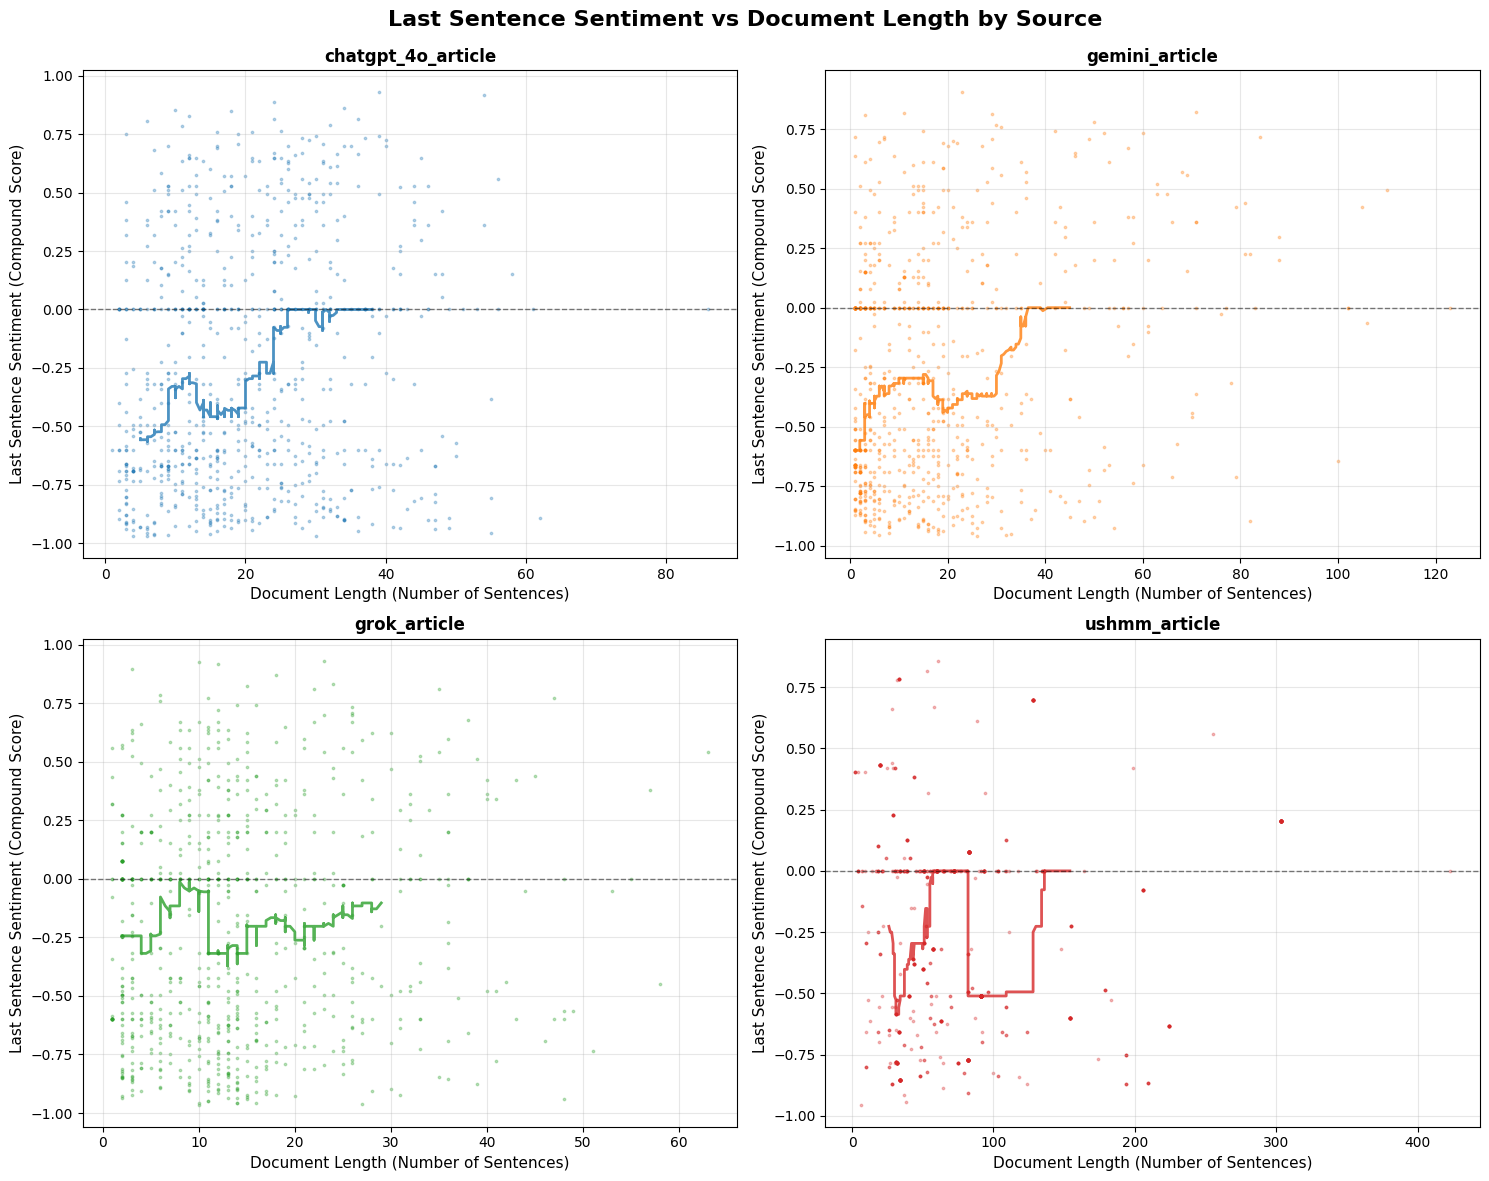

=== SUMMARY STATISTICS ===
Sentiment type: compound
Total documents analyzed: 3242
Document length range: 1 - 423 sentences
Sources: ['chatgpt_4o_article', 'gemini_article', 'grok_article', 'ushmm_article']

Average last sentence compound by source:
                      mean     std  count
source                                   
chatgpt_4o_article -0.2387  0.5082    810
gemini_article     -0.2760  0.4642    811
grok_article       -0.2135  0.4733    810
ushmm_article      -0.2527  0.4139    811


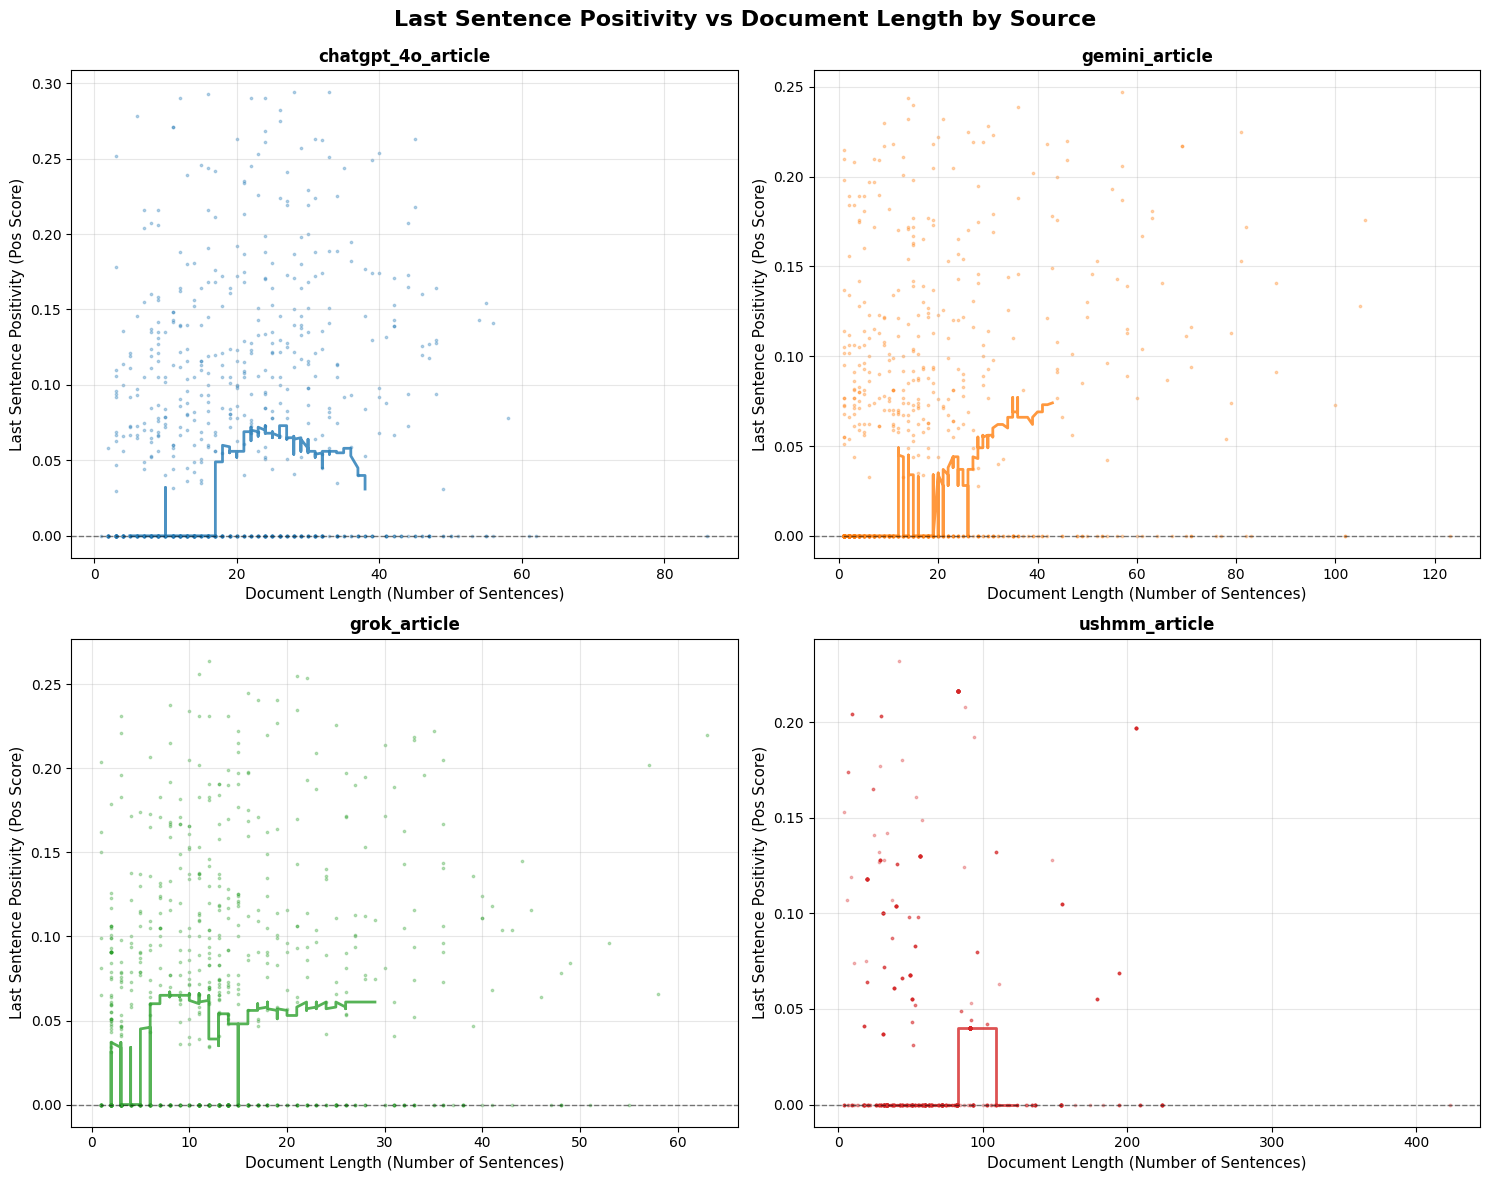

=== SUMMARY STATISTICS ===
Sentiment type: pos
Total documents analyzed: 3242
Document length range: 1 - 423 sentences
Sources: ['chatgpt_4o_article', 'gemini_article', 'grok_article', 'ushmm_article']

Average last sentence pos by source:
                      mean     std  count
source                                   
chatgpt_4o_article  0.0706  0.0921    810
gemini_article      0.0626  0.0987    811
grok_article        0.0672  0.0799    810
ushmm_article       0.0630  0.1011    811


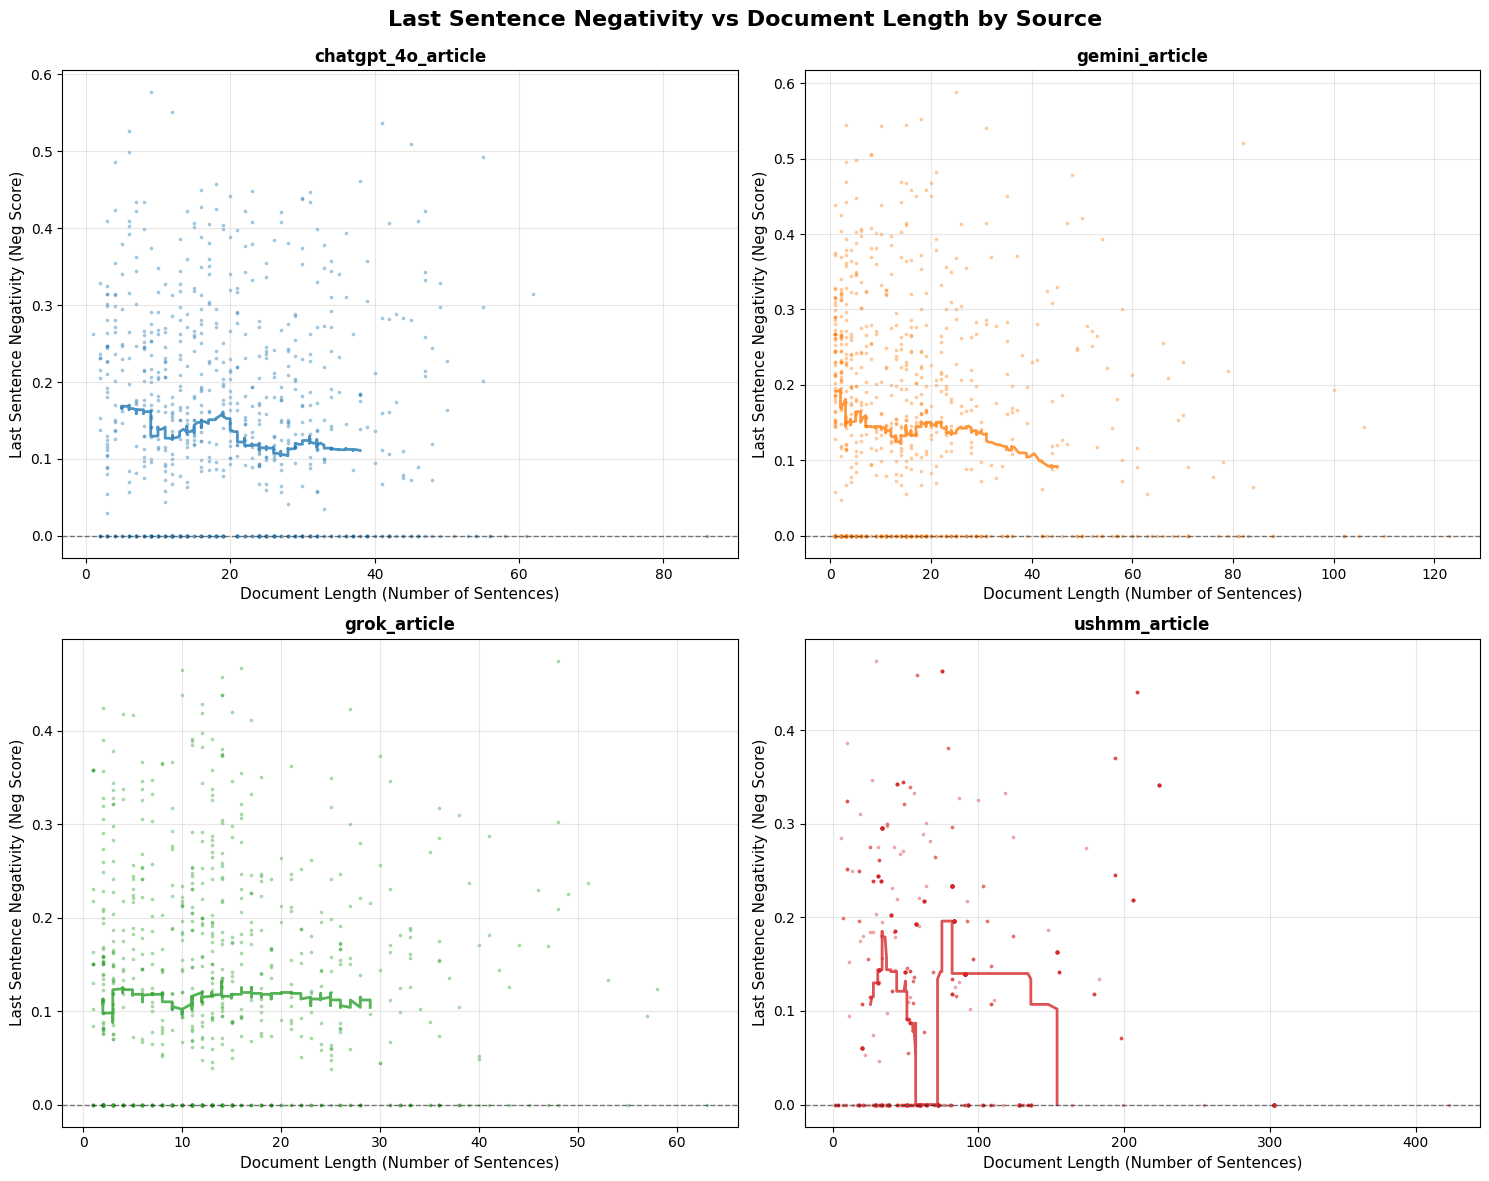

=== SUMMARY STATISTICS ===
Sentiment type: neg
Total documents analyzed: 3242
Document length range: 1 - 423 sentences
Sources: ['chatgpt_4o_article', 'gemini_article', 'grok_article', 'ushmm_article']

Average last sentence neg by source:
                      mean     std  count
source                                   
chatgpt_4o_article  0.1449  0.1313    810
gemini_article      0.1491  0.1395    811
grok_article        0.1244  0.1168    810
ushmm_article       0.1255  0.1205    811


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_last_sentence_sentiment_by_length(df, sentiment_type='compound', text_column='sentence',
                                              source_column='source', doc_id_column='document_id'):
    """
    Analyze average last sentence sentiment as a function of document length per source

    Parameters:
    df: DataFrame with text, source, document_id, and vader sentiment columns
    sentiment_type: 'compound', 'pos', or 'neg'
    text_column: name of column containing text
    source_column: name of column containing source labels
    doc_id_column: name of column containing document IDs
    """

    # Define column names and labels based on sentiment type
    if sentiment_type == 'compound':
        sentiment_col = 'vader_compound'
        y_label = 'Last Sentence Sentiment (Compound Score)'
        title = 'Last Sentence Sentiment vs Document Length by Source'
    elif sentiment_type == 'pos':
        sentiment_col = 'vader_pos'
        y_label = 'Last Sentence Positivity (Pos Score)'
        title = 'Last Sentence Positivity vs Document Length by Source'
    elif sentiment_type == 'neg':
        sentiment_col = 'vader_neg'
        y_label = 'Last Sentence Negativity (Neg Score)'
        title = 'Last Sentence Negativity vs Document Length by Source'
    else:
        raise ValueError("sentiment_type must be 'compound', 'pos', or 'neg'")

    # Group by document_id and source to get document-level info
    doc_stats = []

    for (doc_id, source), group in df.groupby([doc_id_column, source_column]):
        # Get document length (number of sentences)
        doc_length = len(group)

        # Get last sentence sentiment (assuming sentences are ordered)
        last_sentence_sentiment = group.iloc[-1][sentiment_col]

        doc_stats.append({
            'document_id': doc_id,
            'source': source,
            'document_length': doc_length,
            'last_sentence_sentiment': last_sentence_sentiment
        })

    doc_df = pd.DataFrame(doc_stats)

    # Create subplots - 2x2 grid for 4 sources
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()  # Flatten to make indexing easier

    # Define colors and markers for each source
    sources = doc_df['source'].unique()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

    # Plot each source in its own subplot
    for i, source in enumerate(sources):
        ax = axes[i]
        source_data = doc_df[doc_df['source'] == source]

        # Remove outliers using IQR method
        Q1 = source_data['last_sentence_sentiment'].quantile(0.25)
        Q3 = source_data['last_sentence_sentiment'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        source_data_filtered = source_data[(source_data['last_sentence_sentiment'] >= lower_bound) &
                                           (source_data['last_sentence_sentiment'] <= upper_bound)]

        # Plot scatter points (filtered data)
        ax.scatter(source_data_filtered['document_length'],
                   source_data_filtered['last_sentence_sentiment'],
                   color=colors[i % len(colors)],
                   marker='o',
                   alpha=0.3,
                   s=3)

        # Add simple moving median smoothing
        if len(source_data_filtered) > 10:  # Only if enough data points
            # Sort by document length
            sorted_data = source_data_filtered.sort_values('document_length')

            # Simple rolling median with window of 20% of data points
            window_size = max(5, len(sorted_data) // 5)

            x_vals = sorted_data['document_length'].rolling(window=window_size, center=True).median()
            y_vals = sorted_data['last_sentence_sentiment'].rolling(window=window_size, center=True).median()

            # Remove NaN values
            mask = ~(x_vals.isna() | y_vals.isna())

            ax.plot(x_vals[mask], y_vals[mask],
                   color=colors[i % len(colors)],
                   linewidth=2,
                   alpha=0.8)

        # Customize each subplot
        ax.set_xlabel('Document Length (Number of Sentences)', fontsize=11)
        ax.set_ylabel(y_label, fontsize=11)
        ax.set_title(f'{source}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        #ax.set_xscale('log')

        # Add horizontal line at y=0 for reference
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)

    # Add overall title
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)  # Make room for the main title

    # Show the plot
    plt.show()

    # Print summary statistics
    print("=== SUMMARY STATISTICS ===")
    print(f"Sentiment type: {sentiment_type}")
    print(f"Total documents analyzed: {len(doc_df)}")
    print(f"Document length range: {doc_df['document_length'].min()} - {doc_df['document_length'].max()} sentences")
    print(f"Sources: {list(sources)}")
    print(f"\nAverage last sentence {sentiment_type} by source:")
    source_avg = doc_df.groupby('source')['last_sentence_sentiment'].agg(['mean', 'std', 'count']).round(4)
    print(source_avg)

    return doc_df

# Example usage:
# For compound sentiment:
doc_df_compound = analyze_last_sentence_sentiment_by_length(vader_clean, 'compound', 'sentence', 'source', 'doc_id')

# For positivity:
doc_df_pos = analyze_last_sentence_sentiment_by_length(vader_clean, 'pos', 'sentence', 'source', 'doc_id')

# For negativity:
doc_df_neg = analyze_last_sentence_sentiment_by_length(vader_clean, 'neg', 'sentence', 'source', 'doc_id')